In [1]:
import os
import sys
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import dlib
from scipy import ndimage
import tarfile
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%mkdir -p /content/data/
%cd /content/data

train_path = '/content/drive/My Drive/training/training.tar'
val_path = '/content/drive/My Drive/training/validation.tar'
test_path = '/content/drive/My Drive/training/test.tar'

# Load training set and validation set
for fpath in [train_path, val_path, test_path]:
  print('Extracting {}...'.format(fpath.split('/')[-1]))
  with tarfile.open(fpath) as tar:
    tar.extractall()

/content/data
Extracting training.tar...
Extracting validation.tar...
Extracting test.tar...


## **Image Preprocessing**

In [3]:
import os

import cv2
import dlib
import numpy as np
from PIL import Image


class align_faces(object):

    def __call__(self, image):

        # Since the images are loaded it PIL
        image = np.asarray(image)

        # The percentage value of how far in the picture the left eye should be
        LEFT_EYE_CORD = (0.25, 0.2)
        DIMENSIONS = 244

        train_folder = '/content/drive/My Drive/training/'
        predictor_path = os.path.join(train_folder, "shape_predictor_5_face_landmarks.dat")
        detector_path = os.path.join(train_folder, "mmod_human_face_detector.dat")
        shape_predictor = dlib.shape_predictor(predictor_path)
        face_detector = dlib.get_frontal_face_detector()

        # changed here for efficiency
        # face_detector = dlib.cnn_face_detection_model_v1(detector_path)
        faces = face_detector(image)

        if not faces:
            raise ValueError("Image has no detectable faces")

        # assumption is made that there is only one
        for face in faces:
          # face = face_rect.rect
          landmarks = shape_predictor(image, face)
          landmarks = landmarks.parts()
          landmarks = self.convert_to_np(landmarks)

          # To Gauge Scale
          maximum = np.max(landmarks, axis=0)
          minimum = np.min(landmarks, axis=0)

          # eye landmarks
          right = landmarks[:2]
          left = landmarks[2:4]

          left = np.mean(left, axis=0, dtype=np.int)
          right = np.mean(right, axis=0, dtype=np.int)

          centre = np.vstack((left, right))
          centre = np.mean(centre, axis=0, dtype=np.int)

          diff = right - left
          diff = diff.reshape((2, 1))

          angle = np.degrees(np.arctan2(diff[1], diff[0]))

          # find the length of the face, and use that for our scale
          y_scale = maximum[1] - minimum[1]
          y_scale = y_scale + 2.1 * y_scale

          M = cv2.getRotationMatrix2D((centre[0], centre[1]), angle, DIMENSIONS / y_scale)

          # update translation
          t_x = DIMENSIONS // 2
          t_y = DIMENSIONS * LEFT_EYE_CORD[1]
          M[0, 2] += (t_x - centre[0])
          M[1, 2] += (t_y - centre[1])

          image2 = cv2.warpAffine(image, M, (DIMENSIONS, DIMENSIONS),
                                  flags=cv2.INTER_CUBIC)

          # convert back to PIL
          return Image.fromarray(image2)

    @staticmethod
    def convert_to_np(points):
        np_points = np.array([], dtype=np.int)
        while points:
            point = points.pop()
            np_points = np.append(np_points, (point.x, point.y))

        np_points = np_points.reshape((-1, 2))
        np_points = np.flip(np_points, axis=0)
        return np_points

In [4]:
transform = torchvision.transforms.Compose(
    [align_faces(),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.3898, 0.3884, 0.3878), (0.2433, 0.2430, 0.2430))
     ]
)

## **Dataset Creation**

In [5]:
class AUDataset(Dataset):
  """ CK+ dataset labeled by the presence of action units (AU) """
  
  def __init__(self, mode='train', fold=0, transform=None):
    """
    Args:
      - label_csv: Path to the csv file with action unit labels.
      - mode: one of 'train', 'validate' and 'test'
      - fold: one of 0, 1, and 2; determines which folds to use for training
      - transform: transform applied to an image input
    """
    try:
      path_dict = {
          'train': 'training/train_data_',
          'validate': 'validation/valid_data_',
          'test': 'test/test_data'
      }
      self.data_path = '{}{}'.format(path_dict[mode], fold)
      self.label_path = '{}{}_labels.csv'.format(path_dict[mode], fold)
    except KeyError:
      raise ValueError('{} is not a valid mode. Choose train, validation, or test.'.format(mode))
    self.au_frame = pd.read_csv(self.label_path)
    self.label_cols = ['AU_1', 'AU_2', 'AU_4', 'AU_5', 'AU_6', 'AU_7', 
                        'AU_9', 'AU_10', 'AU_12', 'AU_14', 'AU_15', 'AU_17',
                        'AU_20', 'AU_23/24', 'AU_25', 'AU_26/27', 'AU_28',
                        'AU_43']
    self.grayscale = torchvision.transforms.Grayscale(num_output_channels=3)
    self.transform = transform
    

  def __len__(self):
    return len(self.au_frame)

  def __getitem__(self, idx):
    # Get image at idx
    image_id = self.au_frame.iloc[idx]['path']
    image_path = self.data_path + '/' + image_id
    image = cv2.imread(image_path)
    image = Image.fromarray(image)

    # Get AU labels
    aus = self.au_frame.iloc[idx][self.label_cols]
    aus = np.array(aus, dtype=float)

    if self.transform:
      try:
        if int(self.au_frame.iloc[idx]['subject'].split('_')[-1]) > 138:
          image = self.grayscale(image)
        image = self.transform(image)
      except ValueError: # No faces were detected
        return None

    sample = {'image': image, 'labels': aus}

    return sample

## **Other Useful Functions**

In [6]:
def collate_fn(batch):
    """
    Used to process the list of samples to form a batch. Ignores images
    where no faces were detected.
    """
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


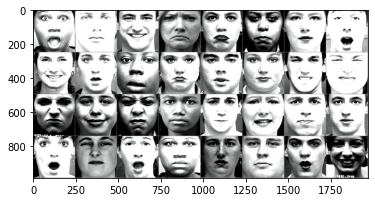

In [28]:
train_set = AUDataset(mode='train', fold=0, transform=transform)
train_loader = DataLoader(train_set, batch_size=32, collate_fn=collate_fn, 
                        shuffle=True)

dataiter = iter(train_loader)
batch = dataiter.next()
imshow(torchvision.utils.make_grid(batch['image']))

## **Training Loop**

In [15]:
import copy
import time

import torchvision
from scipy.io.idl import AttrDict
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np


def validation_step(convnet, val_loader, criterion, bs):
  num_matches = 0.0
  total = 0.0
  losses = []
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  with torch.no_grad():
      for _, item in enumerate(val_loader, 0):

          labels = item.get("labels")
          imgs = item.get("image")
          labels = labels.to(device)
          imgs = imgs.to(device)

          outputs = convnet(imgs)

          # Compute batch loss
          val_loss = criterion(outputs, labels)
          losses.append(val_loss.data.item())

          # Compute batch accuracy, set probabilities > 0.5 to 1
          t = torch.Tensor([0.5])
          t = t.to(device)
          num_matches += ((torch.nn.functional.sigmoid(outputs) > t) == labels).sum()

          total += labels.size(0) * 18

  val_loss = np.mean(losses)
  val_acc = 100 * num_matches / total
  return val_loss, val_acc


def train(convnet, args):
  """Training loop for a single validation fold."""
  train_losses = []
  valid_losses = []
  valid_accs = []
  best_loss = -100 
  start = time.time()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  best_model_wts = copy.deepcopy(convnet.state_dict())

  train_set = AUDataset(mode='train', fold=args.fold, transform=args.transform)
  train_loader = DataLoader(train_set, args.batch_size, collate_fn=collate_fn,
                            shuffle=True, num_workers=args.num_workers)
  
  val_set = AUDataset(mode='validate', fold=args.fold, transform=args.transform)
  val_loader = DataLoader(val_set, args.batch_size, collate_fn=collate_fn,
                          shuffle=True, num_workers=args.num_workers)

  optimizer = torch.optim.Adam(convnet.parameters(), args.learn_rate)
  criterion = torch.nn.BCEWithLogitsLoss()

  if args.resume: 
    print("Loading checkpoint")
    state = torch.load(args.checkpoint)
    convnet.load_state_dict(state['model_state_dict'])
    optimizer.load_state_dict(state['optimizer_state_dict'])


  for epoch in range(args.epochs):
      convnet.train()
      losses = []

      for _, item in enumerate(train_loader, 0):
          
          labels = item.get("labels")
          imgs = item.get("image")

          labels = labels.to(device)
          imgs = imgs.to(device)

          optimizer.zero_grad()

          outputs = convnet(imgs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          losses.append(loss.data.item())


      avg_loss = np.mean(losses)
      train_losses.append(avg_loss)
      time_elapsed = time.time() - start

      print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
          epoch + 1, args.epochs, avg_loss, time_elapsed))
      
      # Validation 
      convnet.eval()
      val_loss, val_acc = validation_step(convnet, val_loader, criterion,
                                          args.batch_size)
      time_elapsed = time.time() - start
      valid_losses.append(val_loss)
      valid_accs.append(val_acc)

      print('Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f' % (
          epoch + 1, args.epochs, val_loss, val_acc, time_elapsed))

      # Save model
      if -val_loss >= best_loss:
        print("Best Loss: Saving Model")
        best_loss = -val_loss
        checkpoint = {
              'model_state_dict': convnet.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_losses': train_losses,
              'valid_losses': valid_losses,
              'best_val_loss': best_loss
          }
        torch.save(checkpoint, args.checkpoint)


def match_state_dict(state_dict):
  """
  Renames 'fc.0' to 'fc.1' and 'fc.2' to 'fc.3' in order to load pretrained
  model weights to new model.
  """
  new_sd = copy.deepcopy(state_dict)
  for key in state_dict:
    if 'fc' in key:
      layer, num, weight = key.split('.')
      if int(num) == 0:
        new_sd['{}.1.{}'.format(layer, weight)] = new_sd.pop(key)
      elif int(num) == 2:
        new_sd['{}.3.{}'.format(layer, weight)] = new_sd.pop(key)
  return new_sd

def get_model():
  """
  Returns a model that has already been pretrained on the CelebA dataset.
  """
  model = models.resnet18(pretrained=True)
  num = model.fc.in_features
  fc = torch.nn.Sequential(
      torch.nn.LeakyReLU(),
      torch.nn.Linear(512, 256), 
      torch.nn.LeakyReLU(),
      torch.nn.Linear(256, 18))
  
  model.fc = fc
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  last_cp = torch.load('/content/drive/My Drive/training/876.pt')
  model_state_dict = match_state_dict(last_cp['model_state_dict'])
  model.load_state_dict(model_state_dict)

  # Freeze feature map layers
  for name, param in model.named_parameters():
    if 'fc' in name:
      param.requires_grad = True
    else:
      param.requires_grad = False
  model = model.to(device)
  return model

## **First Fold**: Unfreeze only FC layers

In [16]:
args = AttrDict()
args_dict = {
    'gpu': True,
    'transform': transform,
    'fold': 0,
    'checkpoint': '/content/drive/MyDrive/training/checkpoints/checkpoint0.pt',
    'learn_rate': 0.0001,
    'batch_size': 32,
    'epochs': 12,
    'num_workers': 4,
    'resume': False 
}

args.update(args_dict)
train(convnet=get_model(), args=args)

Epoch [1/12], Loss: 0.6319, Time (s): 160


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/12], Val Loss: 0.4515, Val Acc: 84.1%, Time(s): 240.67
Best Loss: Saving Model
Epoch [2/12], Loss: 0.3817, Time (s): 398
Epoch [2/12], Val Loss: 0.3413, Val Acc: 87.9%, Time(s): 479.79
Best Loss: Saving Model
Epoch [3/12], Loss: 0.2854, Time (s): 637
Epoch [3/12], Val Loss: 0.2839, Val Acc: 90.0%, Time(s): 718.73
Best Loss: Saving Model
Epoch [4/12], Loss: 0.2475, Time (s): 876
Epoch [4/12], Val Loss: 0.2650, Val Acc: 90.7%, Time(s): 957.69
Best Loss: Saving Model
Epoch [5/12], Loss: 0.2373, Time (s): 1116
Epoch [5/12], Val Loss: 0.2492, Val Acc: 91.1%, Time(s): 1196.60
Best Loss: Saving Model
Epoch [6/12], Loss: 0.2277, Time (s): 1354
Epoch [6/12], Val Loss: 0.2430, Val Acc: 91.4%, Time(s): 1435.35
Best Loss: Saving Model
Epoch [7/12], Loss: 0.2176, Time (s): 1593
Epoch [7/12], Val Loss: 0.2418, Val Acc: 91.5%, Time(s): 1674.15
Best Loss: Saving Model
Epoch [8/12], Loss: 0.2132, Time (s): 1831
Epoch [8/12], Val Loss: 0.2347, Val Acc: 91.6%, Time(s): 1911.49
Best Loss: Saving 

## **Second Fold**: Unfreeze FC layers and last residual block

In [20]:
def get_model():
  """
  Returns a model that has already been pretrained on the CelebA dataset.
  """
  model = models.resnet18(pretrained=True)
  num = model.fc.in_features
  fc = torch.nn.Sequential(
      torch.nn.LeakyReLU(),
      torch.nn.Linear(512, 256), 
      torch.nn.LeakyReLU(),
      torch.nn.Linear(256, 18))
  
  model.fc = fc
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  last_cp = torch.load('/content/drive/My Drive/training/876.pt')
  model_state_dict = match_state_dict(last_cp['model_state_dict'])
  model.load_state_dict(model_state_dict)

  # Freeze feature map layers
  for name, param in model.named_parameters():
    if ('fc' in name) or ('layer4' in name):
      param.requires_grad = True
    else:
      param.requires_grad = False
  model = model.to(device)
  return model

In [21]:
args = AttrDict()
args_dict = {
    'gpu': True,
    'transform': transform,
    'fold': 1,
    'checkpoint': '/content/drive/MyDrive/training/checkpoints/checkpoint1.pt',
    'learn_rate': 0.0001,
    'batch_size': 32,
    'epochs': 12,
    'num_workers': 4,
    'resume': False 
}

args.update(args_dict)
train(convnet=get_model(), args=args)

Epoch [1/12], Loss: 0.4989, Time (s): 162


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/12], Val Loss: 0.2248, Val Acc: 91.5%, Time(s): 236.37
Best Loss: Saving Model
Epoch [2/12], Loss: 0.1791, Time (s): 398
Epoch [2/12], Val Loss: 0.1931, Val Acc: 93.0%, Time(s): 472.29
Best Loss: Saving Model
Epoch [3/12], Loss: 0.1317, Time (s): 632
Epoch [3/12], Val Loss: 0.1794, Val Acc: 93.2%, Time(s): 705.14
Best Loss: Saving Model
Epoch [4/12], Loss: 0.1067, Time (s): 865
Epoch [4/12], Val Loss: 0.1773, Val Acc: 93.7%, Time(s): 938.69
Best Loss: Saving Model
Epoch [5/12], Loss: 0.0885, Time (s): 1099
Epoch [5/12], Val Loss: 0.1672, Val Acc: 93.6%, Time(s): 1171.59
Best Loss: Saving Model
Epoch [6/12], Loss: 0.0733, Time (s): 1332
Epoch [6/12], Val Loss: 0.1695, Val Acc: 93.4%, Time(s): 1404.84
Epoch [7/12], Loss: 0.0640, Time (s): 1565
Epoch [7/12], Val Loss: 0.1730, Val Acc: 93.8%, Time(s): 1637.54
Epoch [8/12], Loss: 0.0492, Time (s): 1797
Epoch [8/12], Val Loss: 0.1699, Val Acc: 93.6%, Time(s): 1870.32
Epoch [9/12], Loss: 0.0394, Time (s): 2029
Epoch [9/12], Val Loss:

## **Third Fold**: Unfreeze FC layers and last two residual blocks

In [22]:
def get_model():
  """
  Returns a model that has already been pretrained on the CelebA dataset.
  """
  model = models.resnet18(pretrained=True)
  num = model.fc.in_features
  fc = torch.nn.Sequential(
      torch.nn.LeakyReLU(),
      torch.nn.Linear(512, 256), 
      torch.nn.LeakyReLU(),
      torch.nn.Linear(256, 18))
  
  model.fc = fc
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  last_cp = torch.load('/content/drive/My Drive/training/876.pt')
  model_state_dict = match_state_dict(last_cp['model_state_dict'])
  model.load_state_dict(model_state_dict)

  # Freeze feature map layers
  for name, param in model.named_parameters():
    if ('fc' in name) or ('layer4' in name) or ('layer3' in name):
      param.requires_grad = True
    else:
      param.requires_grad = False
  model = model.to(device)
  return model

In [23]:
args = AttrDict()
args_dict = {
    'gpu': True,
    'transform': transform,
    'fold': 2,
    'checkpoint': '/content/drive/MyDrive/training/checkpoints/checkpoint2.pt',
    'learn_rate': 0.0001,
    'batch_size': 32,
    'epochs': 12,
    'num_workers': 4,
    'resume': False 
}

args.update(args_dict)
train(convnet=get_model(), args=args)

Epoch [1/12], Loss: 0.5113, Time (s): 153


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/12], Val Loss: 0.2080, Val Acc: 92.3%, Time(s): 234.70
Best Loss: Saving Model
Epoch [2/12], Loss: 0.1860, Time (s): 389
Epoch [2/12], Val Loss: 0.1660, Val Acc: 93.9%, Time(s): 469.67
Best Loss: Saving Model
Epoch [3/12], Loss: 0.1270, Time (s): 624
Epoch [3/12], Val Loss: 0.1618, Val Acc: 94.0%, Time(s): 705.23
Best Loss: Saving Model
Epoch [4/12], Loss: 0.0962, Time (s): 860
Epoch [4/12], Val Loss: 0.1586, Val Acc: 94.4%, Time(s): 940.68
Best Loss: Saving Model
Epoch [5/12], Loss: 0.0753, Time (s): 1095
Epoch [5/12], Val Loss: 0.1563, Val Acc: 94.2%, Time(s): 1176.00
Best Loss: Saving Model
Epoch [6/12], Loss: 0.0629, Time (s): 1330
Epoch [6/12], Val Loss: 0.1504, Val Acc: 94.3%, Time(s): 1410.93
Best Loss: Saving Model
Epoch [7/12], Loss: 0.0484, Time (s): 1565
Epoch [7/12], Val Loss: 0.1532, Val Acc: 94.3%, Time(s): 1645.97
Epoch [8/12], Loss: 0.0422, Time (s): 1799
Epoch [8/12], Val Loss: 0.1544, Val Acc: 94.0%, Time(s): 1879.58
Epoch [9/12], Loss: 0.0377, Time (s): 2033

In [ ]:
from sklearn.metrics import f1_score

def get_metrics(model, data):
  """
  Compute the f1 score for each action unit (AU).
  """
  labels = np.array([], dtype=int).reshape(0,18)
  preds = np.array([], dtype=int).reshape(0,18)
  model.eval() # Set to evaluation mode
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  with torch.no_grad():
    for _, item in enumerate(data, 0):
      batch_labels = item.get("labels")
      labels = np.vstack([labels, batch_labels])
      imgs = item.get("image")
      imgs = imgs.to(device)

      outputs = model(imgs).cpu().detach()

      # Compute batch accuracy, set probabilities > 0.5 to 1
      outputs = torch.nn.functional.sigmoid(outputs).numpy() > 0.5
      preds = np.vstack([preds, outputs])
  
  # Compute f1 scores
  scores = []
  for au in range(18):
    au_labels = labels[:, au]
    au_preds = preds[:, au]
    f1 = f1_score(au_labels, au_preds)
    scores.append(f1)
  return scores
